In [402]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import os
import pickle
from matplotlib.patches import Circle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [395]:
def apply_artificial_homography(points):
    points = np.array(points, dtype=np.float32)
    points[:, 0] += (20 - points[:, 1]) / 20 * points[:, 0]
    return points

boundaries = np.array([[[3, -10], [3, 5]], [[3, 5], [10, 5]], [[10, 10], [3, 10]], [[3, 10], [3, 20]], [[-9, 20], [-9, -10]]], dtype=np.float32)
closed_polygon = np.array([[[-9, -10], [3, -10]], [[3, -10], [3, 5]], [[3, 5], [10, 5]], [[10, 5], [10, 10]], [[10, 10], [3, 10]], [[3, 10], [3, 20]], [[3, 20], [-9, 20]], [[-9, 20], [-9, -10]]], dtype=np.float32)
closed_polygon = apply_artificial_homography(closed_polygon.reshape(-1, 2))
center_line = np.array([[-3, -10], [-3, 20]], dtype=np.float32)
center_line = apply_artificial_homography(center_line)

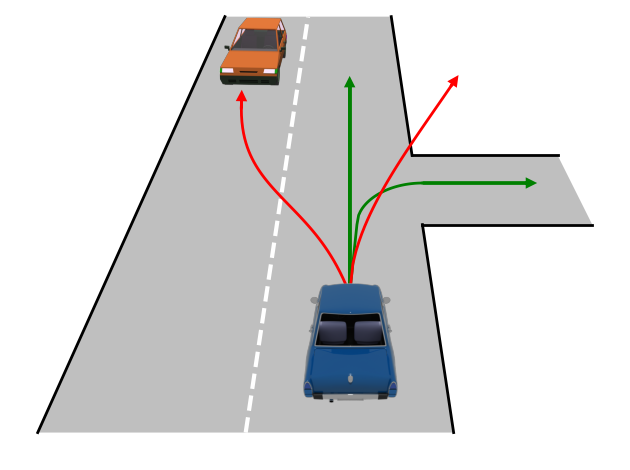

In [46]:
# pull figure
good_trajectories = [[[0, 0], [0, 15]], [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 8]]]
bad_trajectories = [np.stack([np.linspace(0, 6, 50), np.sqrt(np.linspace(0, 6, 50))*6.2], axis=-1), np.stack([np.linspace(0, -6, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(14/(np.tan(1)-np.tan(-1)))], axis=-1)]
for boundary in boundaries:
    boundary = apply_artificial_homography(boundary)
    plt.plot(boundary[:, 0], boundary[:, 1], color='black', linewidth=2)

plt.fill(closed_polygon[:, 0], closed_polygon[:, 1], 'gray', alpha=0.5)

plt.plot(center_line[:, 0], center_line[:, 1], color='white', linewidth=3, linestyle='dashed')

for good_trajectory in good_trajectories:
    good_trajectory = apply_artificial_homography(good_trajectory)
    plt.plot(good_trajectory[:, 0], good_trajectory[:, 1], color='green', linewidth=2)
    plt.arrow(good_trajectory[-2, 0], good_trajectory[-2, 1], good_trajectory[-1, 0] - good_trajectory[-2, 0], good_trajectory[-1, 1] - good_trajectory[-2, 1], color='green', linewidth=2, head_width=0.5, head_length=0.5)
for bad_trajectory in bad_trajectories:
    bad_trajectory = apply_artificial_homography(bad_trajectory)
    plt.plot(bad_trajectory[:, 0], bad_trajectory[:, 1], color='red', linewidth=2)
    plt.arrow(bad_trajectory[-2, 0], bad_trajectory[-2, 1], bad_trajectory[-1, 0] - bad_trajectory[-2, 0], bad_trajectory[-1, 1] - bad_trajectory[-2, 1], color='red', linewidth=2, head_width=0.5, head_length=0.5)

plt.imshow(plt.imread('CarFront.png'), extent=[-9.5, -4.5, 15, 20], zorder=10)
plt.imshow(plt.imread('Ego.png'), extent=[-3.5, 3.5, -8, 1], zorder=10)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('pull_figure.pdf', dpi=300)
plt.show()

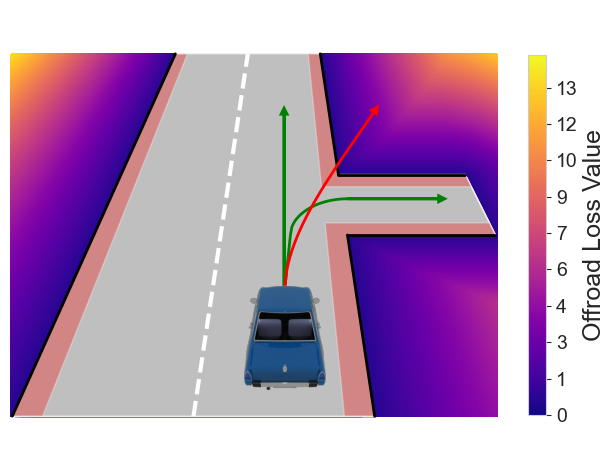

In [408]:
# offroad figure
class OffroadLossPolygons(torch.nn.Module):
    """
    Loss function that penalizes points for being far from the drivable area.
    It accepts a batch of points and a drivable polygon and returns the sum of the distances of each point to the drivable area.
    It has a parameter threshold that is added to the distance to the drivable area, so the loss is zero if the point is inside the drivable area by a margin of threshold.

    The drivable_polygon should be a tensor of shape (B, K, N, 2). For each scene in the batch, there are K polygon, each having N points (the first and last should be the same).
    The points_tensor should be a tensor of shape (B, C, T, 2). B is the batch size, C is the number of prediction modes, and T is the number of time steps.

    You can get the drivable area from a NuScenes map and make a tensor of it like this:
    ```
    drivable_multipolygon = get_drivable_area(instance_token, sample_token, helper, maps)
    polygons = list(drivable_multipolygon)
    polygon_xys = []
    for polygon in polygons:
        # Process the exterior ring
        exterior_xy = np.array(polygon.exterior.coords)
        xy_fixed_size = np.zeros((num_max_points, 2))
        xy_fixed_size[:len(exterior_xy), :] = exterior_xy
        xy_fixed_size[len(exterior_xy):, :] = exterior_xy[-1]
        polygon_xys.append(xy_fixed_size)

        # Process each interior ring (hole)
        for interior in polygon.interiors:
            interior_xy = np.array(interior.coords)
            xy_fixed_size = np.zeros((num_max_points, 2))
            xy_fixed_size[:len(interior_xy), :] = interior_xy
            xy_fixed_size[len(interior_xy):, :] = 200
            polygon_xys.append(xy_fixed_size)
    polygon_xys = np.array(polygon_xys)
    ```
    """
    def __init__(self, threshold=0.5):
        super(OffroadLossPolygons, self).__init__()
        self.threshold = threshold
        self.relu = torch.nn.ReLU()

    def forward(self, points, drivable_multipolygon):
        B, C, T, _ = points.size()
        _, K, N, _ = drivable_multipolygon.size()

        # Expand drivable_multipolygon to match points' dimensions [B, K, 1, 1, N, 2] for broadcasting
        drivable_multipolygon_expanded = drivable_multipolygon.unsqueeze(2).unsqueeze(3).expand(B, K, C, T, N, 2)

        # Points need to be expanded to [B, K, C, T, N, 2] to compute distances to each polygon edge
        points_expanded = points.unsqueeze(1).unsqueeze(4).expand(-1, K, -1, -1, N - 1, -1)

        # Calculate vector from each point to both ends of each polygon edge
        v1 = points_expanded - drivable_multipolygon_expanded[:, :, :, :, :-1, :]

        # Edge vectors
        edge_vectors = drivable_multipolygon_expanded[:, :, :, :, 1:, :] - drivable_multipolygon_expanded[:, :, :, :, :-1, :]

        # Compute dot products
        dot_product = (v1 * edge_vectors).sum(dim=-1)
        edge_sq = (edge_vectors * edge_vectors).sum(dim=-1)
        epsilon = 1e-6
        proj = torch.clamp(dot_product / (edge_sq + epsilon), 0, 1)

        # Find the closest point on the edge to the point
        closest = edge_vectors * proj.unsqueeze(-1) + drivable_multipolygon_expanded[:, :, :, :, :-1, :]

        # Distance from the point to the closest point on the edge
        dist_sq = ((points_expanded - closest) ** 2).sum(dim=-1)
        dist_sq = torch.clamp(dist_sq, min=epsilon)

        # Minimum distance to any of the drivable areas (edges) for each point
        min_dist, _ = torch.sqrt(dist_sq).min(dim=-1)  # Minimum across N-1 edges
        min_dist, _ = min_dist.min(dim=1)  # Minimum across K polygons

        ##################################### Compute the inside mask for each point#####################################
        edge_start = drivable_multipolygon_expanded[:, :, :, :, :-1, :]
        edge_end = drivable_multipolygon_expanded[:, :, :, :, 1:, :]

        cond_y = (edge_start[..., 1] <= points_expanded[..., 1]) & (points_expanded[..., 1] < edge_end[..., 1]) | \
                 (edge_end[..., 1] <= points_expanded[..., 1]) & (points_expanded[..., 1] < edge_start[..., 1])

        edge_slope = (edge_end[..., 1] - edge_start[..., 1]) / (edge_end[..., 0] - edge_start[..., 0] + epsilon)
        intersect_x = edge_start[..., 0] + (points_expanded[..., 1] - edge_start[..., 1]) / (edge_slope + epsilon)

        is_left = intersect_x > points_expanded[..., 0]

        intersection = cond_y & is_left

        # Sum intersections across all polygons before determining if inside/outside
        inside = intersection.sum(dim=-1).sum(dim=1) % 2 == 1

        # Apply the mask to the minimum distances
        # min_dist *= 1 - inside.float()
        min_dist_inside = min_dist * -1

        # Use where to select negative distances for inside points and positive for outside
        min_dist = torch.where(inside, min_dist_inside, min_dist)

        # Apply the threshold
        min_dist = self.relu(min_dist + self.threshold)

        # Here you could sum or mean these distances depending on your loss calculation needs
        # For example, you might want the mean distance per batch or the total sum.
        return min_dist.sum(-1)
    
offroad_loss = OffroadLossPolygons()

bottom_points_perspective = apply_artificial_homography(np.array([[-9, -10], [10, 5]]))
x_range = np.linspace(bottom_points_perspective[0, 0], bottom_points_perspective[1, 0], 100)  # Adjust these values based on your area
y_range = np.linspace(-10, 20, 100)  # Adjust these values based on your area
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_shape = x_grid.shape
points = torch.from_numpy(np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1)).unsqueeze(0).unsqueeze(2)
drivable_polygon = torch.from_numpy(np.array([[[-9, -10], [3, -10]], [[3, -10], [3, 5]], [[3, 5], [10, 5]], [[10, 5], [10, 10]], [[10, 10], [3, 10]], [[3, 10], [3, 20]], [[3, 20], [-9, 20]], [[-9, 20], [-9, -10]]], dtype=np.float32)).unsqueeze(0)
loss_values = offroad_loss(points, drivable_polygon)[0].numpy().reshape(grid_shape)
x_grid = apply_artificial_homography(np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1))[:, 0].reshape(grid_shape)
cnt = plt.contourf(x_grid, y_grid, loss_values, levels=200, cmap='plasma')
for c in cnt.collections:
    c.set_edgecolor("face")
cbar = plt.colorbar(cnt, shrink=0.8)
cbar.set_label(label='Offroad Loss Value', fontsize=18)
cbar.ax.tick_params(labelsize=14)
from matplotlib.ticker import FormatStrFormatter
cbar.formatter = FormatStrFormatter('%d')
cbar.update_ticks()

good_trajectories = [[[0, 0], [0, 15]], [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 8]]]
bad_trajectories = [np.stack([np.linspace(0, 6, 50), np.sqrt(np.linspace(0, 6, 50))*6.2], axis=-1)]
for boundary in boundaries:
    boundary = apply_artificial_homography(boundary)
    plt.plot(boundary[:, 0], boundary[:, 1], color='black', linewidth=2)

plt.fill(closed_polygon[:, 0], closed_polygon[:, 1], 'white')
plt.fill(closed_polygon[:, 0], closed_polygon[:, 1], 'gray', alpha=0.5)

# plot margins
m = 1
margins = [[[-9 + m, -10], [-9 + m, 20], [-9, 20], [-9, -10]],
           [[3 - m, -10], [3-m, 5 + m], [10, 5+m], [10, 10 - m], [3 - m, 10 - m], [3 - m, 20], [3, 20], [3, 10], [10, 10], [10, 5], [3, 5], [3, -10]]]
for margin in margins:
    margin = apply_artificial_homography(margin)
    plt.fill(margin[:, 0], margin[:, 1], 'red', alpha=0.3)

plt.plot(center_line[:, 0], center_line[:, 1], color='white', linewidth=3, linestyle='dashed')

for good_trajectory in good_trajectories:
    good_trajectory = apply_artificial_homography(good_trajectory)
    plt.plot(good_trajectory[:, 0], good_trajectory[:, 1], color='green', linewidth=2)
    plt.arrow(good_trajectory[-2, 0], good_trajectory[-2, 1], good_trajectory[-1, 0] - good_trajectory[-2, 0], good_trajectory[-1, 1] - good_trajectory[-2, 1], color='green', linewidth=2, head_width=0.5, head_length=0.5)
for bad_trajectory in bad_trajectories:
    bad_trajectory = apply_artificial_homography(bad_trajectory)
    plt.plot(bad_trajectory[:, 0], bad_trajectory[:, 1], color='red', linewidth=2)
    plt.arrow(bad_trajectory[-2, 0], bad_trajectory[-2, 1], bad_trajectory[-1, 0] - bad_trajectory[-2, 0], bad_trajectory[-1, 1] - bad_trajectory[-2, 1], color='red', linewidth=2, head_width=0.5, head_length=0.5)

plt.imshow(plt.imread('Ego.png'), extent=[-3.5, 3.5, -8, 1], zorder=10)
plt.axis('equal')
plt.axis('off')
plt.xlim(bottom_points_perspective[0, 0], bottom_points_perspective[1, 0])
plt.ylim(-10, 20)
plt.tight_layout()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('offroad_figure_with_margin.pdf', dpi=300)
plt.show()

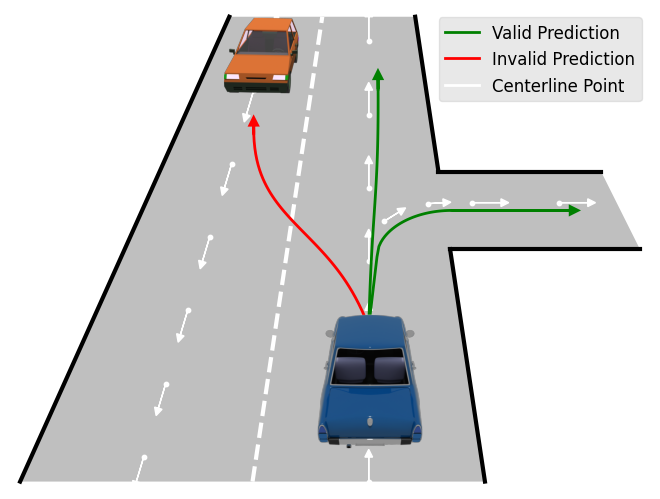

In [276]:
# consistency figure
# good_trajectories = [[[0, 0], [0.5, 15]], [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 8]]]
good_trajectories = [np.stack([np.linspace(0, 0.5, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(16/(np.tan(1)-np.tan(-1)))], axis=-1), [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 4.5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 7.5]]]
bad_trajectories = [np.stack([np.linspace(0, -5.5, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(13/(np.tan(1)-np.tan(-1)))], axis=-1)]

good_centerlines = [np.stack([np.zeros(20), np.linspace(-10, 20, 20)], axis=-1), ]
bad_centerlines = [np.stack([np.ones(20)*-6, np.linspace(20, -10, 20)], axis=-1)]
centerlines = good_centerlines + bad_centerlines + [[[0, 0], [0, 0]] + np.stack([np.linspace(0, 3, 6), 5 + np.sqrt(9 - np.linspace(-3, 0, 6)**2 )]).transpose().tolist() + np.stack([np.linspace(3, 10, 7), np.ones(7) * 8], axis=-1).tolist()]

for boundary in boundaries:
    boundary = apply_artificial_homography(boundary)
    plt.plot(boundary[:, 0], boundary[:, 1], color='black', linewidth=3)

plt.fill(closed_polygon[:, 0], closed_polygon[:, 1], 'gray', alpha=0.5)

plt.plot(center_line[:, 0], center_line[:, 1], color='white', linewidth=3, linestyle='dashed')

for good_trajectory in good_trajectories:
    good_trajectory = apply_artificial_homography(good_trajectory)
    good_trajectory_line = plt.plot(good_trajectory[:, 0], good_trajectory[:, 1], color='green', linewidth=2)
    plt.arrow(good_trajectory[-2, 0], good_trajectory[-2, 1], good_trajectory[-1, 0] - good_trajectory[-2, 0], good_trajectory[-1, 1] - good_trajectory[-2, 1], color='green', linewidth=2, head_width=0.5, head_length=0.5)
for bad_trajectory in bad_trajectories:
    bad_trajectory = apply_artificial_homography(bad_trajectory)
    bad_trajectory_line = plt.plot(bad_trajectory[:, 0], bad_trajectory[:, 1], color='red', linewidth=2)
    plt.arrow(bad_trajectory[-2, 0], bad_trajectory[-2, 1], bad_trajectory[-1, 0] - bad_trajectory[-2, 0], bad_trajectory[-1, 1] - bad_trajectory[-2, 1], color='red', linewidth=2, head_width=0.5, head_length=0.5)

# for good_centerline in good_centerlines:
#     good_centerline = apply_artificial_homography(good_centerline)
#     for i in range(len(good_centerline)-1):
#         plt.arrow(good_centerline[i, 0], good_centerline[i, 1], good_centerline[i+1, 0] - good_centerline[i, 0], good_centerline[i+1, 1] - good_centerline[i, 1], color='white', linewidth=1, head_width=0.5, head_length=0.5, linestyle='dotted')
# 
# for bad_centerline in bad_centerlines:
#     bad_centerline = apply_artificial_homography(bad_centerline)
#     for i in range(len(bad_centerline)-1):
#         plt.arrow(bad_centerline[i, 0], bad_centerline[i, 1], bad_centerline[i+1, 0] - bad_centerline[i, 0], bad_centerline[i+1, 1] - bad_centerline[i, 1], color='white', linewidth=1, head_width=0.5, head_length=0.5, linestyle='dotted')
for centerline in centerlines:
    centerline = apply_artificial_homography(centerline)
    # plt.plot(centerline[:, 0], centerline[:, 1], color='white', linewidth=1)
    for i in range(0, len(centerline)-1, 3):
        plt.arrow(centerline[i, 0], centerline[i, 1], centerline[i+1, 0] - centerline[i, 0], centerline[i+1, 1] - centerline[i, 1], color='white', linewidth=1, head_width=0.5, head_length=0.5)
        plt.scatter(centerline[i, 0], centerline[i, 1], color="white", s=10)

centerline_line = plt.plot([0, 0], [0, 0], color='white', linewidth=2)
plt.legend([good_trajectory_line[0], bad_trajectory_line[0], centerline_line[0]], ['Valid Prediction', 'Invalid Prediction', 'Centerline Point'], fontsize=12, facecolor='lightgray', framealpha=0.5)
plt.imshow(plt.imread('CarFront.png'), extent=[-9.5, -4.5, 15, 20], zorder=10)
plt.imshow(plt.imread('Ego.png'), extent=[-3.5, 3.5, -8, 1], zorder=10)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('consistency_figure.pdf', dpi=300)
plt.show()

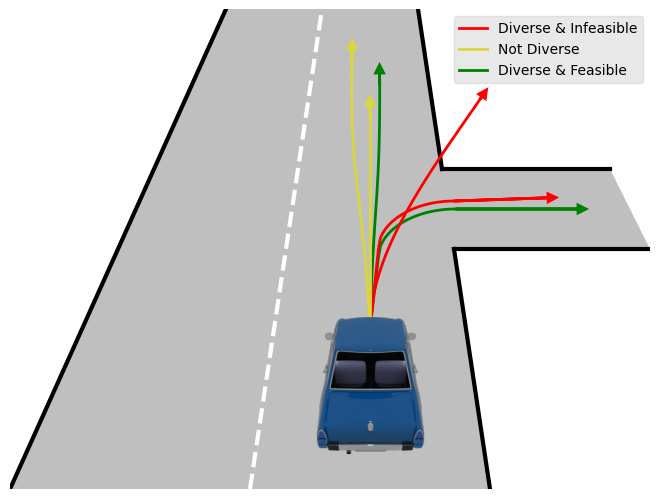

In [279]:
# diversity figure
# good_trajectories = [[[0, 0], [0.5, 15]], [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 8]]]
good_trajectories = [np.stack([np.linspace(0, 0.5, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(16/(np.tan(1)-np.tan(-1)))], axis=-1), 
                     [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 4.5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[8, 7.5]]]
bad_trajectories = [ np.stack([np.linspace(0, 5.5, 50), np.sqrt(np.linspace(0, 5.5, 50))*6.2], axis=-1),
                     [[0, 0]] + np.stack([np.linspace(0.3, 3.3, 40), 5 + np.sqrt(9 - np.linspace(-3, 0, 40)**2 )]).transpose().tolist() + [[7, 8.2]]]
non_diverse_trajectories = [np.stack([np.linspace(0, -1, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(17.5/(np.tan(1)-np.tan(-1)))], axis=-1),
                            np.stack([np.linspace(0, 0, 50), (np.tan(np.linspace(-1, 1, 50))-np.tan(-1))*(14/(np.tan(1)-np.tan(-1)))], axis=-1)]

for boundary in boundaries:
    boundary = apply_artificial_homography(boundary)
    plt.plot(boundary[:, 0], boundary[:, 1], color='black', linewidth=3)

plt.fill(closed_polygon[:, 0], closed_polygon[:, 1], 'gray', alpha=0.5)

plt.plot(center_line[:, 0], center_line[:, 1], color='white', linewidth=3, linestyle='dashed')

for good_trajectory in good_trajectories:
    good_trajectory = apply_artificial_homography(good_trajectory)
    good_trajectory_line = plt.plot(good_trajectory[:, 0], good_trajectory[:, 1], color='green', linewidth=2)
    plt.arrow(good_trajectory[-2, 0], good_trajectory[-2, 1], good_trajectory[-1, 0] - good_trajectory[-2, 0], good_trajectory[-1, 1] - good_trajectory[-2, 1], color='green', linewidth=2, head_width=0.5, head_length=0.5)
for bad_trajectory in bad_trajectories:
    bad_trajectory = apply_artificial_homography(bad_trajectory)
    bad_trajectory_line = plt.plot(bad_trajectory[:, 0], bad_trajectory[:, 1], color='red', linewidth=2)
    plt.arrow(bad_trajectory[-2, 0], bad_trajectory[-2, 1], bad_trajectory[-1, 0] - bad_trajectory[-2, 0], bad_trajectory[-1, 1] - bad_trajectory[-2, 1], color='red', linewidth=2, head_width=0.5, head_length=0.5)
for non_diverse_trajectory in non_diverse_trajectories:
    non_diverse_trajectory = apply_artificial_homography(non_diverse_trajectory)
    non_diverse_trajectory_line = plt.plot(non_diverse_trajectory[:, 0], non_diverse_trajectory[:, 1], color='#d9d63f', linewidth=2)
    plt.arrow(non_diverse_trajectory[-2, 0], non_diverse_trajectory[-2, 1], non_diverse_trajectory[-1, 0] - non_diverse_trajectory[-2, 0], non_diverse_trajectory[-1, 1] - non_diverse_trajectory[-2, 1], color='#d9d63f', linewidth=2, head_width=0.5, head_length=0.5)
plt.legend([bad_trajectory_line[0], non_diverse_trajectory_line[0], good_trajectory_line[0]], ['Diverse & Infeasible', 'Not Diverse', 'Diverse & Feasible'], loc='upper right', fontsize=10, facecolor='lightgray', framealpha=0.5)

# plt.imshow(plt.imread('CarFront.png'), extent=[-9.5, -4.5, 15, 20], zorder=10)
plt.imshow(plt.imread('Ego.png'), extent=[-3.5, 3.5, -8, 1], zorder=10)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('diversity_figure.pdf', dpi=300)
plt.show()

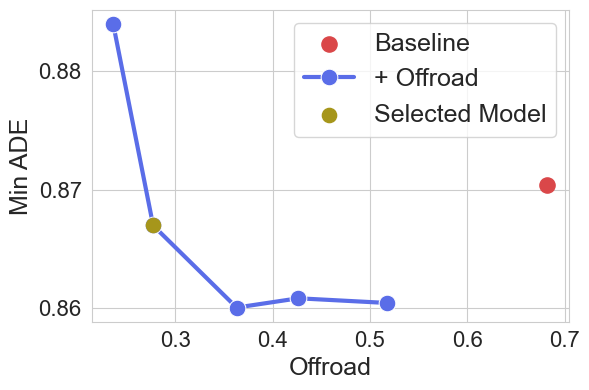

In [397]:
# offroad vs minADE figure
offroads, minADEs = [], []
names_ordered = [f"wayformer-av2-{id}.pickle" for id in [f"offroad-ow{w}-aw1.0" for w in [0.01, 0.03, 0.3, 1, 10]] + ["baseline"]]
for key in names_ordered:
    with open("unitraj/preds_and_losses/" + key, "rb") as f:
        preds_and_losses = pickle.load(f)
    offroads.append(preds_and_losses['losses']['offroad'].mean())
    minADEs.append(preds_and_losses['losses']['minADE6'].mean())
    
fig, ax = plt.subplots(figsize=(6, 4))
baseline = plt.scatter(offroads[-1], minADEs[-1], marker='o', color="#DA4749", s=120, label='Baseline')
with_offroad = sns.lineplot(x=offroads[:-1], y=minADEs[:-1], marker='o', linestyle='-', color="#5a6de8", linewidth=3, markersize=12, label='+ Offroad')
plt.scatter(offroads[1], minADEs[1], s=105, color="#a6961b", label="Selected Model", zorder=10)

plt.legend(frameon=True, loc='best', fontsize=18)
plt.xlabel('Offroad', fontsize=18)
plt.ylabel('Min ADE', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks([0.86, 0.87, 0.88], fontsize=16)
# plt.grid()
plt.tight_layout()
plt.savefig('offroad_minADE.pdf', dpi=300)
plt.show()

[0.4880443, 0.8160448, 1.0980229, 1.4095062, 1.8952348, 2.3105044, 2.7970345, 3.2602322, 4.269909] [2.3021345, 1.1661938, 0.96576166, 0.8941118, 0.8732258, 0.86380523, 0.8683176, 0.8667397, 0.87038404]


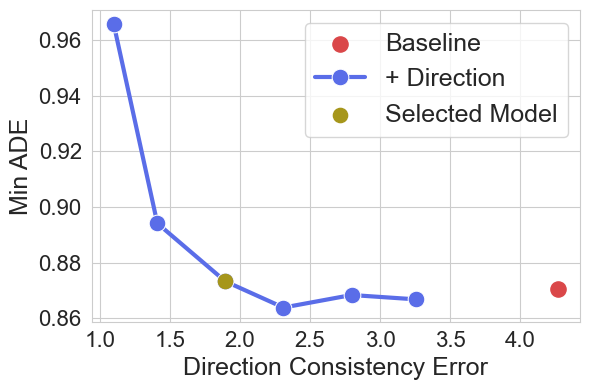

In [398]:
# consistency vs minADE figure
consistency, minADEs = [], []
names_ordered = [f"wayformer-av2-{id}.pickle" for id in [f"consistency-ow{w}-aw1.02" for w in [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]] + ["baseline"]]
for key in names_ordered:
    with open("unitraj/preds_and_losses/" + key, "rb") as f:
            preds_and_losses = pickle.load(f)
    consistency.append(preds_and_losses['losses']['consistency'].mean())
    minADEs.append(preds_and_losses['losses']['minADE6'].mean())
print(consistency, minADEs)
fig, ax = plt.subplots(figsize=(6, 4))
baseline = plt.scatter(consistency[-1], minADEs[-1], marker='o', color="#DA4749", s=120, label='Baseline')
with_consistency = sns.lineplot(x=consistency[2:-1], y=minADEs[2:-1], marker='o', linestyle='-', color="#5a6de8", linewidth=3, markersize=12, label='+ Direction')
plt.scatter(consistency[4], minADEs[4], s=105, color="#a6961b", label="Selected Model", zorder=10)
plt.legend(frameon=True, loc='best', fontsize=18)
plt.xlabel('Direction Consistency Error', fontsize=18)
plt.ylabel('Min ADE', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.grid()
plt.tight_layout()
plt.savefig('consistency_minADE.pdf', dpi=300)
plt.show()

[57.480328, 57.63691, 58.197678, 60.046684, 64.03862, 109.21573, 247.03673, 57.44058] [0.8703509, 0.8703762, 0.8706202, 0.87223154, 0.87818485, 0.9400514, 1.372857, 0.87038404]


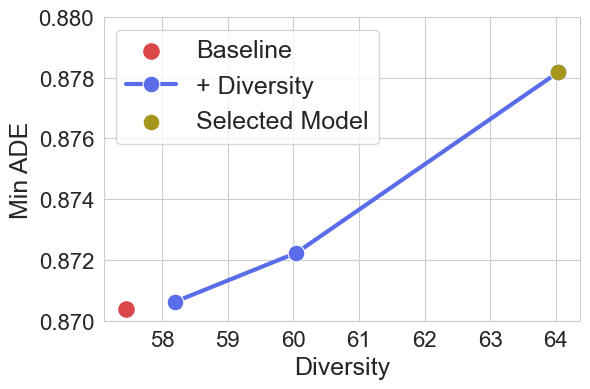

In [399]:
# consistency vs minADE figure
diversity, minADEs = [], []
names_ordered = [f"wayformer-av2-{id}.pickle" for id in [f"diversity-ow1.0-aw{w}-ft-all-points" for w in [0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 1]] + ["baseline"]]
for key in names_ordered:
    with open("unitraj/preds_and_losses/" + key, "rb") as f:
            preds_and_losses = pickle.load(f)
    diversity.append(preds_and_losses['losses']['diversity'].mean())
    minADEs.append(preds_and_losses['losses']['minADE6'].mean())
print(diversity, minADEs)
fig, ax = plt.subplots(figsize=(6, 4))
baseline = plt.scatter(diversity[-1], minADEs[-1], marker='o', color="#DA4749", s=120, label='Baseline')
with_consistency = sns.lineplot(x=diversity[2:-3], y=minADEs[2:-3], marker='o', linestyle='-', color="#5a6de8", linewidth=3, markersize=12, label='+ Diversity')
plt.scatter(diversity[4], minADEs[4], s=105, color="#a6961b", label="Selected Model", zorder=10)
plt.legend(frameon=True, loc='best', fontsize=18)
plt.xlabel('Diversity', fontsize=18)
plt.ylabel('Min ADE', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.linspace(0.870, 0.880, 6), fontsize=16)
# plt.grid()
plt.tight_layout()
plt.savefig('diversity_minADE.pdf', dpi=300)
plt.show()

In [296]:
# table 1
preds_and_losses = {}
weights = {"wayformer": {"av2": {"offroad": 0.03, "consistency": 0.3, "diversity": 0.5}, 
                         "nuscenes": {"offroad": 1, "consistency": 1, "diversity": 1}}, 
           "autobot": {"av2": {"offroad": 0.003, "consistency": 0.003, "diversity": 3}, 
                       "nuscenes": {"offroad": 0.01, "consistency": 0.01, "diversity": 10}}}
all_ckpt_paths = {"wayformer": {"nuscenes": "wayformer-nuscenes-combination-ow1.0-or33.33-cn33.33-dv1.50-ft",
                                    "av2": "wayformer-av2-combination-ow2.0-or333.33-cn33.33-dv1.00-ft"},
                      "autobot": {"nuscenes": "autobot-nuscenes-combination-ow1.0-or333.33-cn100.00-dv6.00-ft",
                                  "av2": "autobot-av2-combination-ow1.0-or3333.33-cn333.33-dv3.00-ft"}}
preds_and_losses_paths = [all_ckpt_paths[model][dataset] + ".pickle" for model in ["wayformer", "autobot"] for dataset in ["av2", "nuscenes"]]
for model in ["wayformer", "autobot"]:
    for dataset in ["av2", "nuscenes"]:
        preds_and_losses_paths.append(f"{model}-{dataset}-baseline.pickle")
        for loss in ["offroad", "consistency"]:
            preds_and_losses_paths.append(f"{model}-{dataset}-{loss}-ow{weights[model][dataset][loss]}-aw1.0{'2' if loss=='consistency' and (model != 'wayformer' or dataset != 'nuscenes') else ''}.pickle")
        preds_and_losses_paths.append(f"{model}-{dataset}-diversity-ow1.0-aw{weights[model][dataset]['diversity']}-ft-all-points.pickle")

for preds_and_losses_path in preds_and_losses_paths:
    with open("unitraj/preds_and_losses/" + preds_and_losses_path, "rb") as f:
        preds_and_losses[preds_and_losses_path] = pickle.load(f)

gt_consistency = {"av2": np.load("GT_consistency_av2.npy"), "nuscenes": np.load("GT_consistency_nuscenes.npy")}
con_thresh = {"av2": np.percentile(gt_consistency["av2"], 95), "nuscenes": np.percentile(gt_consistency["nuscenes"], 99)}

def do_print(print_name, key):
    print(print_name, end=" & ")
    for dataset in ["nuscenes", "av2"]:
        for loss in ["minADE6", "minFDE6", "miss_rate", "offroad"]:
            print(f"{preds_and_losses[key[dataset]]['losses'][loss].mean():.2f}", end=" & ")
        print(f"{preds_and_losses[key[dataset]]['losses']['consistency'][gt_consistency[dataset] <= con_thresh[dataset]].mean():.2f}", end=" & ")
        print(f"{preds_and_losses[key[dataset]]['losses']['diversity'].mean():.0f}", end="\\\\\n" if dataset == "av2" else " & ")

print(f"GT & 0 & 0 & 0 & 0.12 & {gt_consistency['nuscenes'][gt_consistency['nuscenes'] <= con_thresh['nuscenes']].mean():.2f} & - & 0 & 0 & 0 & 0.16 & {gt_consistency['av2'][gt_consistency['av2'] <= con_thresh['av2']].mean():.2f} & - \\\\")
print("\\midrule")

for model, print_name in [("wayformer", "Wayformer"), ("autobot", "Autobots")]:
    do_print(print_name, { "nuscenes": f"{model}-nuscenes-baseline.pickle", "av2": f"{model}-av2-baseline.pickle"})
    for loss, loss_print_name in [("offroad", "+ Offroad"), ("consistency", "+ Direction")]:
            key_nuscenes = f"{model}-nuscenes-{loss}-ow{weights[model]['nuscenes'][loss]}-aw1.0{'2' if (loss=='consistency' and model != 'wayformer') else ''}.pickle"
            key_av2 = f"{model}-av2-{loss}-ow{weights[model]['av2'][loss]}-aw1.0{'2' if loss=='consistency' else ''}.pickle"
            do_print(loss_print_name, { "nuscenes": key_nuscenes, "av2": key_av2})
    key_nuscenes = f"{model}-nuscenes-diversity-ow1.0-aw{weights[model]['nuscenes']['diversity']}-ft-all-points.pickle"
    key_av2 = f"{model}-av2-diversity-ow1.0-aw{weights[model]['av2']['diversity']}-ft-all-points.pickle"
    do_print("+ Diversity", { "nuscenes": key_nuscenes, "av2": key_av2})
    # print("+ All & ? & ? & ? & ? & ? & ? & ? & ? & ? & ? & ? & ? \\\\")
    do_print("+ All", { "nuscenes": all_ckpt_paths[model]["nuscenes"]+".pickle", 
                        "av2": all_ckpt_paths[model]["av2"]+".pickle"})
    print("\\midrule")

GT & 0 & 0 & 0 & 0.12 & 2.27 & - & 0 & 0 & 0 & 0.16 & 3.15 & - \\
\midrule
Wayformer & 1.08 & 2.47 & 0.42 & 2.73 & 7.68 & 57 & 0.87 & 1.79 & 0.30 & 0.68 & 4.24 & 57\\
+ Offroad & 1.07 & 2.54 & 0.43 & 1.58 & 6.46 & 70 & 0.87 & 1.78 & 0.28 & 0.28 & 3.65 & 60\\
+ Direction & 1.13 & 2.60 & 0.43 & 1.56 & 5.27 & 57 & 0.87 & 1.80 & 0.28 & 0.34 & 1.89 & 58\\
+ Diversity & 1.10 & 2.55 & 0.46 & 2.83 & 8.22 & 74 & 0.88 & 1.81 & 0.31 & 0.69 & 4.29 & 64\\
+ All & 1.13 & 2.61 & 0.43 & 1.67 & 5.47 & 67 & 0.89 & 1.85 & 0.30 & 0.44 & 2.54 & 63\\
\midrule
Autobots & 1.27 & 2.70 & 0.43 & 1.93 & 5.80 & 64 & 0.92 & 1.86 & 0.30 & 0.30 & 3.67 & 58\\
+ Offroad & 1.26 & 2.65 & 0.41 & 1.09 & 4.94 & 65 & 0.86 & 1.68 & 0.25 & 0.21 & 3.75 & 59\\
+ Direction & 1.26 & 2.64 & 0.41 & 1.04 & 4.21 & 67 & 0.88 & 1.73 & 0.26 & 0.20 & 1.70 & 60\\
+ Diversity & 1.27 & 2.69 & 0.49 & 1.81 & 5.96 & 93 & 0.87 & 1.72 & 0.27 & 0.31 & 3.79 & 62\\
+ All & 1.26 & 2.70 & 0.43 & 1.01 & 4.27 & 74 & 0.95 & 1.99 & 0.33 & 0.19 & 1.94 & 63

In [387]:
# table 2
def do_print(offroads):
    original_offroads, attacked_offroads = offroads
    smooth_offroads = np.stack([attacked_offroads['smooth-turn'][i] for i in [  -3, -2, -1, 1, 2, 3]])
    double_offroads = np.stack([attacked_offroads['double-turn'][i] for i in [  -3, -2, -1, 1, 2, 3]])
    ripple_offroads = np.stack([attacked_offroads['ripple-road'][i] for i in [  -3, -2, -1, 1, 2, 3]])
    print(f"{np.mean(original_offroads):.2f} & "
          f"{np.mean([smooth_offroads.mean(), double_offroads.mean(), ripple_offroads.mean()]):.2f}"
          # f"{double_offroads.mean():.2f} & "
          # f"{ripple_offroads.mean():.2f}" 
          , end="")
for model, print_name in [("autobot", "Autobots"), ("wayformer", "Wayformer")]:
    print(print_name, end=" & ")
    for dataset in ["nuscenes", "av2"]:
        with open(f"unitraj/attacked_offroads_{model}_{dataset}_baseline.pkl", "rb") as f:
            baseline = pickle.load(f)
        do_print(baseline)
        if dataset == "av2":
            print("\\\\")
        else:
            print(" & ", end="")
    print("+ Offroad", end=" & ")
    for dataset in ["nuscenes", "av2"]:
        with open(f"unitraj/attacked_offroads_{model}_{dataset}_offroad.pkl", "rb") as f:
            offroad = pickle.load(f)
        do_print(offroad)
        if dataset == "av2":
            print("\\\\")
        else:
            print(" & ", end="")
    print("+ All", end=" & ")
    for dataset in ["nuscenes", "av2"]:
        with open(f"unitraj/attacked_offroads_{model}_{dataset}_combination.pkl", "rb") as f:
            all = pickle.load(f)
        do_print(all)
        if dataset == "av2":
            print("\\\\")
        else:
            print(" & ", end="")
    print("\\midrule")

Autobots & 1.93 & 4.69 & 0.30 & 1.19\\
+ Offroad & 1.09 & 3.34 & 0.21 & 1.01\\
+ All & 1.01 & 3.09 & 0.19 & 0.80\\
\midrule
Wayformer & 2.73 & 8.89 & 0.68 & 4.16\\
+ Offroad & 1.58 & 7.41 & 0.28 & 1.69\\
+ All & 1.67 & 6.93 & 0.44 & 3.53\\
\midrule


In [378]:
# percentage of offroad improvement
wayformer_nuscenes = (2.73 - 1.56) / 2.73
wayformer_av2 = (0.68 - 0.28) / 0.68
autobot_nuscenes = (1.93 - 1.01) / 1.93
autobot_av2 = (0.30 - 0.19) / 0.30
print(wayformer_nuscenes, wayformer_av2, autobot_nuscenes, autobot_av2)
print(np.mean([wayformer_nuscenes, wayformer_av2, autobot_nuscenes, autobot_av2]) * 100)

0.42857142857142855 0.5882352941176471 0.47668393782383417 0.36666666666666664
46.50393317948941


In [388]:
# percentage of attack improvement
wayformer_nuscenes = (8.89 - 6.93) / 8.89
wayformer_av2 = (4.16 - 1.69) / 4.16
autobot_nuscenes = (4.69 - 3.09) / 4.69
autobot_av2 = (1.19 - 0.8) / 1.19
print(wayformer_nuscenes, wayformer_av2, autobot_nuscenes, autobot_av2)
print(np.mean([wayformer_nuscenes, wayformer_av2, autobot_nuscenes, autobot_av2]) * 100)

0.22047244094488197 0.59375 0.34115138592750544 0.32773109243697474
37.077622982734056
